In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
import patsy

from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from pysal.model import mgwr
from mgwr.sel_bw import Sel_BW

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [5]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}
import math
from geopandas import GeoDataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
import mcdm

In [4]:
pip install mcdm

     |████████████████████████████████| 69 kB 543 kB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 1.3 MB/s eta 0:00:01    |███████████▍                    | 5.6 MB 1.4 MB/s eta 0:00:08     |███████████▊                    | 5.8 MB 1.4 MB/s eta 0:00:08     |█████████████▍                  | 6.6 MB 1.4 MB/s eta 0:00:07     |█████████████████▊              | 8.7 MB 1.1 MB/s eta 0:00:07     |██████████████████              | 8.9 MB 1.1 MB/s eta 0:00:07     |███████████████████▌            | 9.6 MB 1.1 MB/s eta 0:00:06     |███████████████████▉            | 9.7 MB 1.1 MB/s eta 0:00:06     |█████████████████████▍          | 10.5 MB 1.8 MB/s eta 0:00:03     |████████████████████████▏       | 11.9 MB 1.8 MB/s eta 0:00:03
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.1
    Uninstalling numpy-1.19.1:
      Successfully uninstalled numpy-1.19.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip

In [13]:
##node1 bus stop count
GBA_area=gpd.read_file('metro_data/GBA/GBA_area.shp',encoding="utf-8")
GBA_station=gpd.read_file('metro_data/GBA/GBA_railstation.shp',encoding="gbk")
GBA_station_id = pd.read_csv('metro_data/GBA/GBA_station.csv',low_memory=False,
                 usecols=['WGS84_Lng','sid'])

In [14]:
gba_station=GBA_station[['站名简','WGS84_Lng','NL_NAME_2','geometry']]
GBA_station_id.rename(columns={'sid':'id'},inplace=True)
gba_station=pd.merge(gba_station,GBA_station_id,on='WGS84_Lng',how='left')
gba_station=gba_station.drop(['id'],axis=1)
gba_station['id']=gba_station.index.values+1
gba_area=pd.merge(gba_station,GBA_area,on='id',how='right')

In [15]:
gba_area=gba_area.drop(['geometry_x'],axis=1)
gba_area.rename(columns={'geometry_y':'geometry'},inplace=True)

In [16]:
gba_area = GeoDataFrame(gba_area, crs="EPSG:4326", geometry=gba_area.geometry)
gba_station = GeoDataFrame(gba_station, crs="EPSG:4326", geometry=gba_station.geometry)

In [20]:
gba_area.rename(columns={'站名简':'station_name'},inplace=True)
gba_station.rename(columns={'站名简':'station_name'},inplace=True)

In [21]:
gba_station.to_file('gba_station_raw.shp')
gba_area.to_file('gba_area_raw.shp')

In [26]:
gba_area

,station_name,WGS84_Lng,NL_NAME_2,id,time,geometry,N_busStop_Count
0,虎门站,113.6683,东莞市,1,20,"POLYGON ((113.69630 22.99585, 113.69759 22.991...",2929
1,东莞站,113.8540,东莞市,2,20,"POLYGON ((113.88198 23.15958, 113.88398 23.157...",3939
2,常平站,114.0013,东莞市,3,20,"POLYGON ((114.01727 23.05427, 114.01832 23.052...",2637
3,东莞东站,114.0340,东莞市,4,20,"POLYGON ((113.98595 23.08306, 113.98728 23.081...",2678
4,樟木头站,114.0622,东莞市,5,20,"POLYGON ((114.06822 22.98713, 114.06962 22.979...",1644
5,三水南站,112.8663,佛山市,6,20,"POLYGON ((112.83828 23.24110, 112.83890 23.239...",3013
6,三水站,112.8828,佛山市,7,20,"POLYGON ((112.79476 23.27794, 112.79517 23.273...",3595
7,佛山站,113.0984,佛山市,8,20,"POLYGON ((113.19642 23.16299, 113.19642 23.156...",8387
8,碧江站,113.2571,佛山市,9,20,"POLYGON ((113.20112 23.08093, 113.20177 23.072...",5137
9,北滘站,113.2583,佛山市,10,20,"POLYGON ((113.27832 22.97383, 113.27845 22.970...",4773


In [25]:
gba_bus_station=gpd.read_file('metro_data/GBA/amap_bus_stops_gba.shp',encoding="utf-8")
gba_bus_station_count = gpd.sjoin(gba_bus_station, gba_area, how='right')
gba_bus_station_count_test = gba_bus_station_count.groupby(['id'])['stop_id'].agg(N_busStop_Count='count').reset_index()
gba_area = pd.merge(gba_area, gba_bus_station_count_test, on='id',how='left')

In [52]:
#各站点每日服务车次
china_train = pd.read_excel('metro_data/GBA/china_station.xlsx')

In [53]:
china_train.head()

,station_no,station_train_code,train_class_name,station_name,arrive_time,start_time,stopover_time
0,1,D1,动车,北京,18:07,18:07,----
1,2,D1,动车,唐山北,19:18,19:20,2分钟
2,3,D1,动车,北戴河,20:16,20:18,2分钟
3,4,D1,动车,沈阳,23:23,23:28,5分钟
4,5,D1,动车,沈阳南,23:40,23:40,----


In [54]:
china_train_test = china_train.groupby(['station_name'])['station_no'].agg(N_train_Count='count').reset_index()

In [55]:
china_train_test.head()

,station_name,N_train_Count
0,一步滩,2
1,一面坡,11
2,一面坡北,10
3,一面山,3
4,七台河,6


In [56]:
gba_test=gba_area.copy()
gba_test["站名简"]= gba_test["站名简"].str.replace("站", "", case = False)

In [58]:
gba_test.rename(columns={'站名简':'station_name'},inplace=True)
gba_test=pd.merge(gba_test,china_train_test,on='station_name',how='left')

In [60]:
gba_test['N_train_Count']=gba_test['N_train_Count'].fillna(0)

In [70]:
gba_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   station_name     74 non-null     object  
 1   WGS84_Lng        74 non-null     float64 
 2   NL_NAME_2        74 non-null     object  
 3   id               74 non-null     int64   
 4   time             74 non-null     int64   
 5   geometry         74 non-null     geometry
 6   N_busStop_Count  74 non-null     int64   
 7   N_train_Count    74 non-null     float64 
 8   N_busline_Cover  74 non-null     float64 
dtypes: float64(3), geometry(1), int64(3), object(2)
memory usage: 5.8+ KB


In [68]:
gba_area=gba_test.copy()

In [67]:
##node 公交线路覆盖率
road_total = pd.read_csv('metro_data/GBA/road_length.csv',low_memory=False, encoding="utf-8",
                 usecols=['road_length',"id"])
bus_line_length = pd.read_csv('metro_data/GBA/bus_line_length.csv',low_memory=False, encoding="utf-8",
                 usecols=['bus_line_length',"id"])

In [69]:
road_total = pd.merge(road_total, bus_line_length, on='id')
road_total['N_busline_Cover']=road_total.bus_line_length/road_total.road_length
temp=road_total[['N_busline_Cover','id']]
gba_area=pd.merge(gba_area,temp,on='id',how='left')

In [71]:
#node-对外交通道路所占比例
external_road = pd.read_csv('metro_data/GBA/external_length.csv',low_memory=False, encoding="utf-8",
                 usecols=['external_length',"id"])
external_road = pd.merge(external_road, road_total, on='id')
external_road['N_external_Coverage']=external_road.external_length/external_road.road_length
temp=external_road[['id','N_external_Coverage']]
gba_area=pd.merge(gba_area,temp,on='id',how='left')

In [72]:
#place-范围内人口总数
pop_area = pd.read_csv('metro_data/GBA/gba_pop.csv',low_memory=False, encoding="utf-8",
                 usecols=['pop',"id"])
fs_pop = pop_area.groupby(['id'])['pop'].agg(P_pop_sum='sum').reset_index()
gba_area=pd.merge(fs_pop,gba_area,on='id',how='right')

In [73]:
#node-交通用地占比/place-基本功能占比/非基本功能占比
basic_function = pd.read_csv('metro_data/GBA/gba_basic.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id"])
unbasic_function = pd.read_csv('metro_data/GBA/gba_unbasic.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id"])
transpotation_function = pd.read_csv('metro_data/GBA/gba_transportation.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id"])
area = pd.read_csv('metro_data/gba/area.csv',low_memory=False, encoding="utf-8",
                 usecols=['area',"id"])
gba_area=pd.merge(area,gba_area,on='id',how='right')

In [74]:
basic_function = basic_function.groupby(['id'])['LU_area'].agg(basic_sum='sum').reset_index()
unbasic_function = unbasic_function.groupby(['id'])['LU_area'].agg(unbasic_sum='sum').reset_index()
transpotation_function = transpotation_function.groupby(['id'])['LU_area'].agg(transpotation_sum='sum').reset_index()

In [75]:
gba_area = pd.merge(gba_area, basic_function, on='id',how='left')
gba_area = pd.merge(gba_area, unbasic_function, on='id',how='left')
gba_area = pd.merge(gba_area, transpotation_function, on='id',how='left')

In [76]:
gba_area['N_transland_Cover']=gba_area.transpotation_sum/gba_area.area
gba_area['P_basic_Cover']=gba_area.basic_sum/gba_area.area
gba_area['P_unbasic_Cover']=gba_area.unbasic_sum/gba_area.area

In [77]:
gba_area= gba_area.drop(['transpotation_sum','basic_sum','unbasic_sum'],axis=1)

In [78]:
gba_area['N_transland_Cover'] = gba_area['N_transland_Cover'].fillna(0)
gba_area['P_basic_Cover'] = gba_area['P_basic_Cover'].fillna(0)
gba_area['P_unbasic_Cover'] = gba_area['P_unbasic_Cover'].fillna(0)

In [79]:
gba_area.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   74 non-null     int64   
 1   area                 74 non-null     float64 
 2   P_pop_sum            74 non-null     int64   
 3   station_name         74 non-null     object  
 4   WGS84_Lng            74 non-null     float64 
 5   NL_NAME_2            74 non-null     object  
 6   time                 74 non-null     int64   
 7   geometry             74 non-null     geometry
 8   N_busStop_Count      74 non-null     int64   
 9   N_train_Count        74 non-null     float64 
 10  N_busline_Cover      74 non-null     float64 
 11  N_external_Coverage  74 non-null     float64 
 12  N_transland_Cover    74 non-null     float64 
 13  P_basic_Cover        74 non-null     float64 
 14  P_unbasic_Cover      74 non-null     float64 
dtypes: float64(8), geometry(1

In [81]:
#Place-Degree of landuse mix---entropy 熵 Frank（2005）
landuse_area = pd.read_csv('metro_data/GBA/gba_landuse.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id",'Level1'])
test = landuse_area.groupby(['id','Level1'])['LU_area'].agg(LU_sum='sum').reset_index()
test1 = pd.pivot_table(test, index='id', columns='Level1', values='LU_sum')
test2 = pd.DataFrame(test1.to_records())

In [82]:
test_list=[]
for i in range (0,74):
    p=test2.loc[[i]].isna().sum().sum()
    test_list.append(p)

In [83]:
test2['na_vlaue']=test_list
test2['conf']=5
test2['n3']=test2.conf-test2.na_vlaue

In [84]:
test2['1'] = test2['1'].fillna(0)
test2['2'] = test2['2'].fillna(0)
test2['3'] = test2['3'].fillna(0)
test2['4'] = test2['4'].fillna(0)
test2['5'] = test2['5'].fillna(0)
test2['sum']=test2['1']+test2['2']+test2['3']+test2['4']+test2['5']

In [85]:
(test2['sum'] != 0).all()

True

In [86]:
LUM_list=[]
for i in range (0,74):
    if test2.at[i,'1']==0:
        t1=0
    else:
        t1=math.log(test2.at[i,'1']/test2.at[i,'sum'])
    if test2.at[i,'2']==0:
        t2=0
    else:
        t2=math.log(test2.at[i,'2']/test2.at[i,'sum'])
    if test2.at[i,'3']==0:
        t3=0
    else:
        t3=math.log(test2.at[i,'3']/test2.at[i,'sum'])
    if test2.at[i,'4']==0:
        t4=0
    else:
        t4=math.log(test2.at[i,'4']/test2.at[i,'sum'])
    if test2.at[i,'5']==0:
        t5=0
    else:
        t5=math.log(test2.at[i,'5']/test2.at[i,'sum'])
    p=(-1)*((test2.at[i,'1']/test2.at[i,'sum'])*t1
                   +(test2.at[i,'2']/test2.at[i,'sum'])*t2
                  +(test2.at[i,'3']/test2.at[i,'sum'])*t3
                  +(test2.at[i,'4']/test2.at[i,'sum'])*t4
                  +(test2.at[i,'5']/test2.at[i,'sum'])*t5)/math.log(test2.at[i,'n3'])
    LUM_list.append(p)

In [87]:
test2['P_LUM']=LUM_list
test2['P_LUM'] = test2['P_LUM'].fillna(0)

In [88]:
LUM_df = test2[['id', 'P_LUM']]
gba_area = pd.merge(gba_area, LUM_df, on='id',how='left')

In [89]:
#place2-Simpson Diversity Index(poi)
def simpson_di(data):

    """ Given a hash { 'species': count } , returns the Simpson Diversity Index
    
    >>> simpson_di({'a': 10, 'b': 20, 'c': 30,})
    0.3888888888888889
    """

    N = sum(data.values())
    
    def p(n, N):
        """ Relative abundance """
        if n is  0:
            return 0
        else:
            return (float(n)*(n-1))/(N*(N-1))

    
    return 1-sum(p(n, N) for n in data.values() if n is not 0)

In [90]:
gba_area = GeoDataFrame(gba_area, crs="EPSG:4326", geometry=gba_area.geometry)
gba_area['P_LUM'] = gba_area['P_LUM'].fillna(0)

In [91]:
gz_area2=gba_area.copy()

In [92]:
gz_poi_cy=gpd.read_file('metro_data/GBA/poi/餐饮.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_cy, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['id'])['gml_id'].agg(cy_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='id')

In [93]:
gz_poi_ds=gpd.read_file('metro_data/GBA/poi/大厦.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_ds, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(ds_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [94]:
gz_poi_mall=gpd.read_file('metro_data/GBA/poi/大型购物广场.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_mall, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(mall_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [95]:
gz_poi_gw=gpd.read_file('metro_data/GBA/poi/购物.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_gw, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(gw_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [96]:
gz_poi_jr=gpd.read_file('metro_data/GBA/poi/金融服务.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_jr, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(jr_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [97]:
gz_poi_ky=gpd.read_file('metro_data/GBA/poi/科研教育.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_ky, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(ky_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [98]:
gz_poi_ly=gpd.read_file('metro_data/GBA/poi/旅游.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_ly, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(ly_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [99]:
gz_poi_xs=gpd.read_file('metro_data/GBA/poi/休闲娱乐.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_xs, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(xs_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [100]:
gz_poi_zf=gpd.read_file('metro_data/GBA/poi/政府机关.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_zf, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(zf_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [101]:
gz_poi_zs=gpd.read_file('metro_data/GBA/poi/住宿.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_zs, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(zs_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [102]:
gba_area['P_poi_Diversity']=0.1

In [103]:
gz_area2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   74 non-null     int64   
 1   area                 74 non-null     float64 
 2   P_pop_sum            74 non-null     int64   
 3   station_name         74 non-null     object  
 4   WGS84_Lng            74 non-null     float64 
 5   NL_NAME_2            74 non-null     object  
 6   time                 74 non-null     int64   
 7   geometry             74 non-null     geometry
 8   N_busStop_Count      74 non-null     int64   
 9   N_train_Count        74 non-null     float64 
 10  N_busline_Cover      74 non-null     float64 
 11  N_external_Coverage  74 non-null     float64 
 12  N_transland_Cover    74 non-null     float64 
 13  P_basic_Cover        74 non-null     float64 
 14  P_unbasic_Cover      74 non-null     float64 
 15  P_LUM            

In [104]:
for i in range(0,74):
    poi_dic={'a':gz_area2['cy_Count'][i],'b':gz_area2['ds_Count'][i],'c':gz_area2['mall_Count'][i],
             'd':gz_area2['gw_Count'][i],'e':gz_area2['jr_Count'][i],'f':gz_area2['ky_Count'][i],
             'g':gz_area2['ly_Count'][i],'h':gz_area2['xs_Count'][i],'i':gz_area2['zf_Count'][i],
             'j':gz_area2['zs_Count'][i]}
    gba_area['P_poi_Diversity'][i]=simpson_di(poi_dic)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [105]:
gba_area['P_poi_Diversity'] = gba_area['P_poi_Diversity'].fillna(0)

In [107]:
gba_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   74 non-null     int64   
 1   area                 74 non-null     float64 
 2   P_pop_sum            74 non-null     int64   
 3   station_name         74 non-null     object  
 4   WGS84_Lng            74 non-null     float64 
 5   NL_NAME_2            74 non-null     object  
 6   time                 74 non-null     int64   
 7   geometry             74 non-null     geometry
 8   N_busStop_Count      74 non-null     int64   
 9   N_train_Count        74 non-null     float64 
 10  N_busline_Cover      74 non-null     float64 
 11  N_external_Coverage  74 non-null     float64 
 12  N_transland_Cover    74 non-null     float64 
 13  P_basic_Cover        74 non-null     float64 
 14  P_unbasic_Cover      74 non-null     float64 
 15  P_LUM            

In [108]:
###测量correlation
gba_cor2=gba_area.copy()
gba_cor2= gba_cor2.drop(['id','WGS84_Lng','NL_NAME_2','geometry','station_name','area','time'],axis=1)

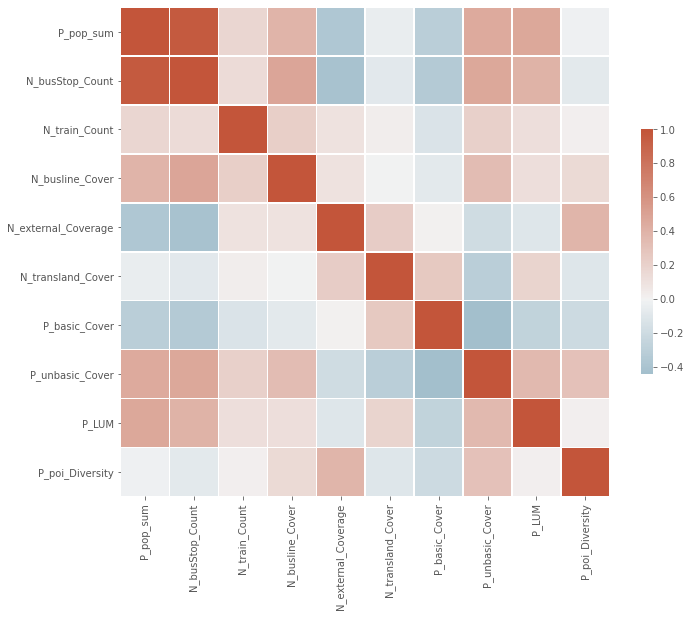

In [109]:
corrMatrix=gba_cor2.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plot1=sns.heatmap(corrMatrix,  cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [110]:
plot1.figure.savefig("corr_gba.png",dpi=300)

In [111]:
gba_area.to_csv('gba_all_variables.csv',encoding='utf-8',index=False)

In [112]:
#分析
gba_PCA=gba_area.copy()

In [113]:
gba_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   74 non-null     int64   
 1   area                 74 non-null     float64 
 2   P_pop_sum            74 non-null     int64   
 3   station_name         74 non-null     object  
 4   WGS84_Lng            74 non-null     float64 
 5   NL_NAME_2            74 non-null     object  
 6   time                 74 non-null     int64   
 7   geometry             74 non-null     geometry
 8   N_busStop_Count      74 non-null     int64   
 9   N_train_Count        74 non-null     float64 
 10  N_busline_Cover      74 non-null     float64 
 11  N_external_Coverage  74 non-null     float64 
 12  N_transland_Cover    74 non-null     float64 
 13  P_basic_Cover        74 non-null     float64 
 14  P_unbasic_Cover      74 non-null     float64 
 15  P_LUM            

In [114]:
#PCA for Node
features_N = ['N_busStop_Count', 'N_train_Count', 'N_busline_Cover','N_external_Coverage','N_transland_Cover'
           ]
# Separating out the features
x_N = gba_PCA.loc[:, features_N].values
# Standardizing the features
x_N =MinMaxScaler().fit_transform(x_N)#MinMaxScaler/StandardScaler

#PCA for Plcae
features_P = ['P_poi_Diversity', 'P_pop_sum', 'P_basic_Cover', 'P_unbasic_Cover','P_LUM'
           ]
# Separating out the features
x_P = gba_PCA.loc[:, features_P].values
# Standardizing the features
x_P = MaxAbsScaler().fit_transform(x_P)

In [115]:
Node_arry=mcdm.weighting.critic(x_N)
Node_wgt=Node_arry.tolist()
Place_arry=mcdm.weighting.critic(x_P)
Place_wgt=Place_arry.tolist()

In [116]:
###测量correlation
gba_index=gba_area.copy()
gba_index= gba_index.drop(['id','WGS84_Lng','NL_NAME_2','geometry','station_name','area','time'],axis=1)

In [117]:
scaler = MinMaxScaler()
# fit and transform the data
gz_norm = pd.DataFrame(scaler.fit_transform(gba_index), columns=gba_index.columns)

In [126]:
#计算各维度index
gz_norm['Node_index']=gz_norm.N_busStop_Count*Node_wgt[0]+gz_norm.N_train_Count*Node_wgt[1]+gz_norm.N_busline_Cover*Node_wgt[2]+gz_norm.N_external_Coverage*Node_wgt[3]+gz_norm.N_transland_Cover*Node_wgt[4]
gz_norm['Place_index']=gz_norm.P_poi_Diversity*Place_wgt[0]+gz_norm.P_pop_sum*Place_wgt[1]+gz_norm.P_basic_Cover*Node_wgt[2]+gz_norm.P_unbasic_Cover*Place_wgt[3]+gz_norm.P_LUM*Place_wgt[4]

In [127]:
gz_final=gz_norm[['Node_index','Place_index']]
gz_final['id']=gz_final.index.values+1

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [128]:
gba_final_area=pd.merge(gba_area,gz_final,on='id',how='left')
gz_temp=gba_final_area[['id','Node_index','Place_index']]

In [129]:
gba_station.head()

,站名简,WGS84_Lng,NL_NAME_2,geometry,id
0,虎门站,113.6683,东莞市,MULTIPOINT (113.66829 22.86435),1
1,东莞站,113.8540,东莞市,MULTIPOINT (113.85398 23.09034),2
2,常平站,114.0013,东莞市,MULTIPOINT (114.00127 22.98583),3
3,东莞东站,114.0340,东莞市,MULTIPOINT (114.03395 22.96989),4
4,樟木头站,114.0622,东莞市,MULTIPOINT (114.06222 22.90412),5


In [130]:
gba_final_station=pd.merge(gba_station,gz_temp,on='id',how='right')

In [132]:
gba_final_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   74 non-null     int64   
 1   area                 74 non-null     float64 
 2   P_pop_sum            74 non-null     int64   
 3   station_name         74 non-null     object  
 4   WGS84_Lng            74 non-null     float64 
 5   NL_NAME_2            74 non-null     object  
 6   time                 74 non-null     int64   
 7   geometry             74 non-null     geometry
 8   N_busStop_Count      74 non-null     int64   
 9   N_train_Count        74 non-null     float64 
 10  N_busline_Cover      74 non-null     float64 
 11  N_external_Coverage  74 non-null     float64 
 12  N_transland_Cover    74 non-null     float64 
 13  P_basic_Cover        74 non-null     float64 
 14  P_unbasic_Cover      74 non-null     float64 
 15  P_LUM            

In [135]:
gba_final_station.rename(columns={'站名简':'station_name'},inplace=True)

In [136]:
gba_final_station.to_file("gba_station_withindex.shp")
gba_final_area.to_file("gba_area_withindex.shp")